In [1]:
import numpy as np
import os
import re
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt


import numpy as np
import tensorflow as tf
import keras
from skimage.transform import resize

from keras.layers import Conv2D,UpSampling2D
from keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import ReduceLROnPlateau

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import concatenate, RepeatVector, Reshape, Input

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [3]:
# defining the size of the image
SIZE = 224

In [4]:
def extract_color_traintest(path, train_size, test_size, size):

    color_img_train = []
    color_img_test = []
    files = os.listdir(path)
    files = sorted_alphanumeric(files)

    for i in tqdm(range(len(files))):


        if i < train_size:
            img = cv2.imread(os.path.join(path, files[i]), 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (size, size))
            img = img.astype('float32') / 255.0
            color_img_train.append(img_to_array(img))


        elif i < (train_size + test_size):  # Use the next test_size images for testing
            img = cv2.imread(os.path.join(path, files[i]), 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (size, size))
            img = img.astype('float32') / 255.0
            color_img_test.append(img_to_array(img))

            
        else:
            break

    return color_img_train, color_img_test

In [5]:
path = 'C://Users/rkven/Downloads/Landscapes_DLCASESTUDY/LandScape_Images/color'

train_size = 4000
test_size = 1000
size = SIZE  # Replace with the desired size

color_img_train, color_img_test = extract_color_traintest(path, train_size, test_size, size)

 70%|███████   | 5000/7129 [00:10<00:04, 488.70it/s]


In [7]:
print("Training color images: ",len(color_img_train))
print("Testing color images: ",len(color_img_test))

Training color images:  4000
Testing color images:  1000


In [8]:
def extract_gray_traintest(path, train_size, test_size, size):

    gray_img_train = []
    gray_img_test = []
    files = os.listdir(path)
    files = sorted_alphanumeric(files)

    for i in tqdm(range(len(files))):


        if i < train_size:
            img = cv2.imread(os.path.join(path, files[i]), 1)
            img = cv2.resize(img, (size, size))
            img = img.astype('float32') / 255.0
            gray_img_train.append(img_to_array(img))


        elif i < (train_size + test_size):  # Use the next test_size images for testing
            img = cv2.imread(os.path.join(path, files[i]), 1)
            img = cv2.resize(img, (size, size))
            img = img.astype('float32') / 255.0
            gray_img_test.append(img_to_array(img))

        else:
            break

    return gray_img_train, gray_img_test

In [9]:
path2 = 'C://Users/rkven/Downloads/Landscapes_DLCASESTUDY/LandScape_Images/gray'

train_size = 4000
test_size = 1000
size = SIZE  # Replace with the desired size

gray_img_train, gray_img_test = extract_gray_traintest(path2, train_size, test_size, size)

 70%|███████   | 5000/7129 [00:09<00:03, 554.46it/s]


In [10]:
print("Training Grayscale Images: ",len(gray_img_train))
print("Testing Grayscale Images: ",len(gray_img_test))

Training Grayscale Images:  4000
Testing Grayscale Images:  1000


In [11]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('GrayscaleImage', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Color Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

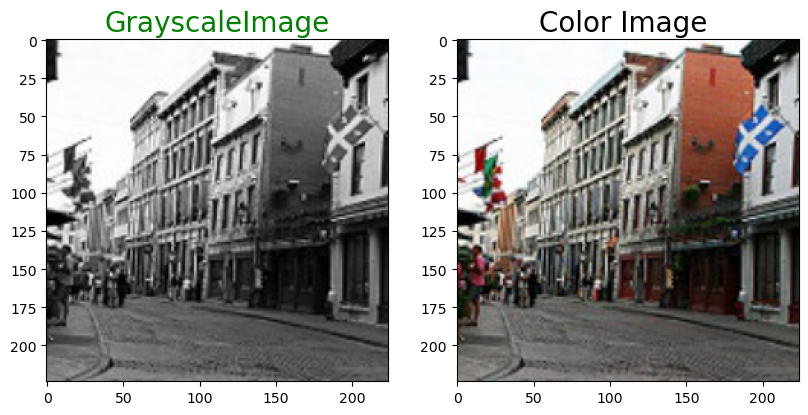

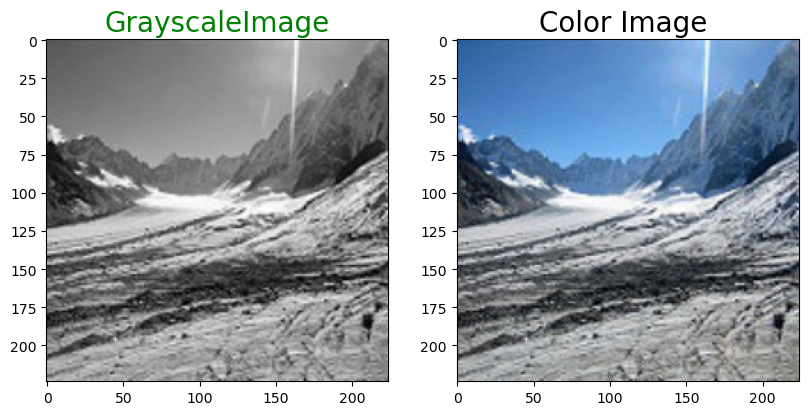

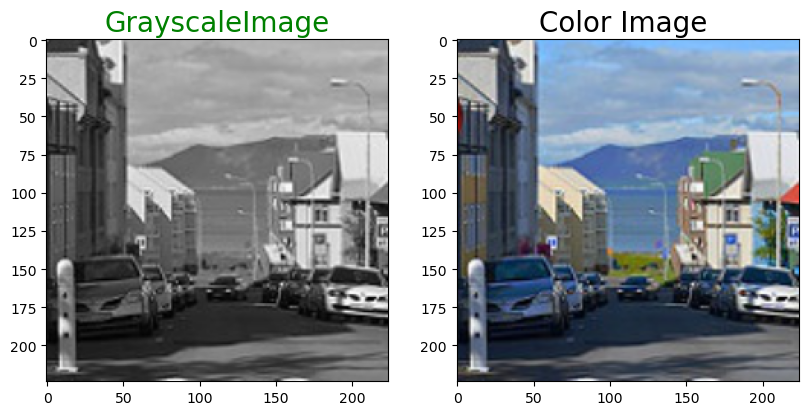

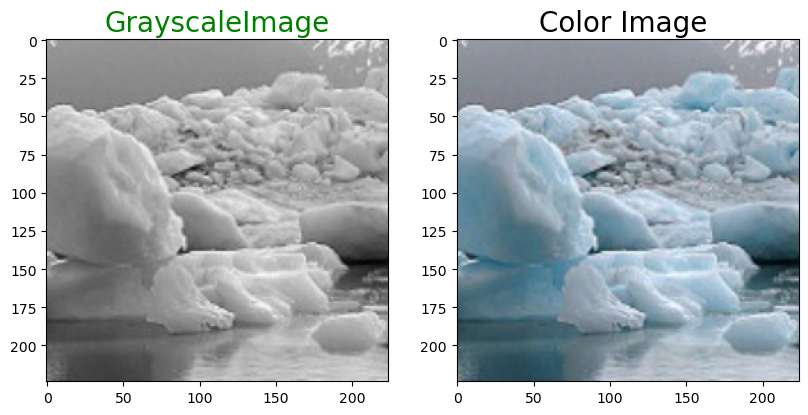

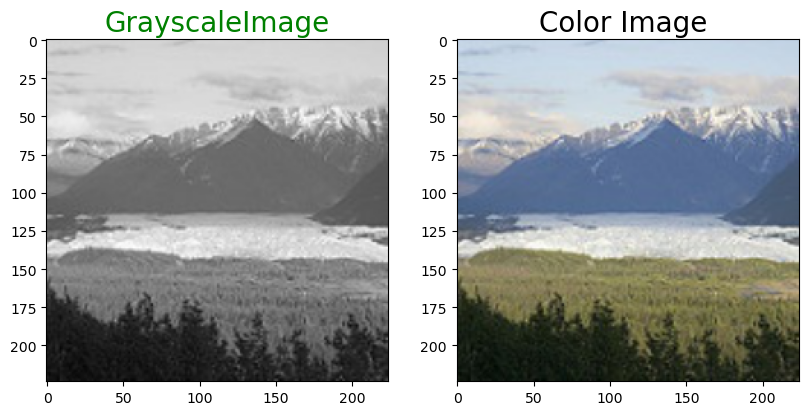

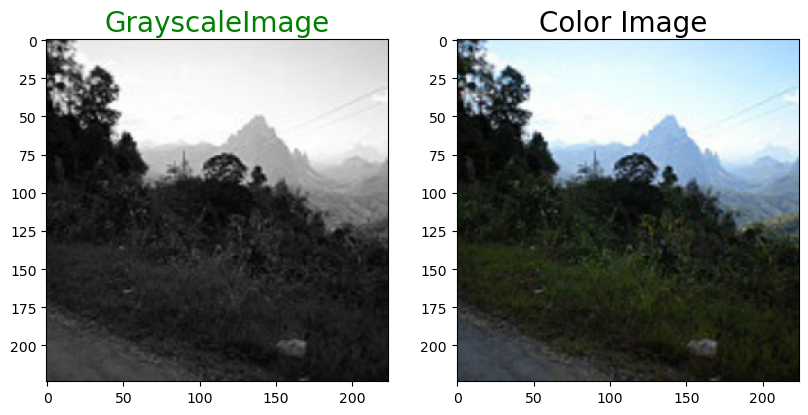

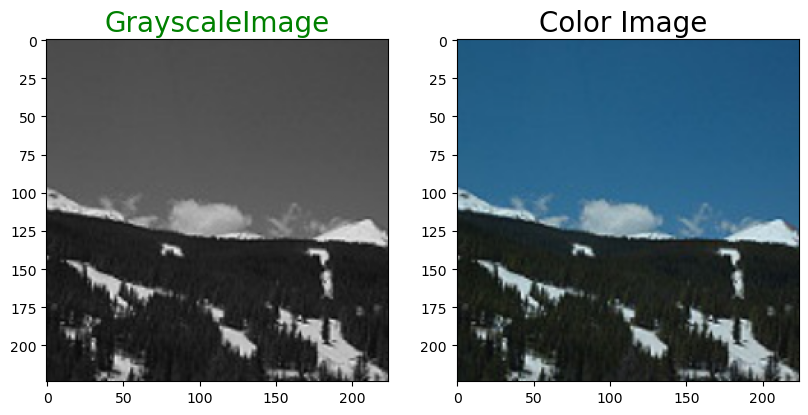

In [12]:
for i in range(3,10):
     plot_images(gray_img_train[i],color_img_train[i])

In [13]:
def convert_to_lab(color_images):
    
    gray_channels = []
    ab_channels = []
    
    for img in color_images:
        # Convert color image to LAB format
        try:
            
            lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            lab_img = lab_img.astype('float32')

            gray_channels.append(lab_img[:,:,0] / 100.0)
            ab_channels.append(lab_img[:,:,1:] / 128.0)

        except:
            print('error')

    gray_channels = np.array(gray_channels)
    ab_channels = np.array(ab_channels)
    
    gray_channels = gray_channels.reshape(gray_channels.shape+(1,)) #dimensions to be the same for X and Y
    
    return gray_channels, ab_channels

In [14]:
lab_gray_train_images, lab_ab_train_images = convert_to_lab(color_img_train)

In [15]:
print(lab_gray_train_images.shape)
print(lab_ab_train_images.shape)

(4000, 224, 224, 1)
(4000, 224, 224, 2)


In [16]:
lab_gray_test_images, lab_ab_test_images = convert_to_lab(color_img_test)

In [17]:
print(lab_gray_test_images.shape)
print(lab_ab_test_images.shape)

(1000, 224, 224, 1)
(1000, 224, 224, 2)


In [20]:
def autoencoder():

    #ENCODER
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2, input_shape=(224, 224, 1)))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))

    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))

    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
    

    #DECODER

    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='softmax', padding='same'))
    model.add(UpSampling2D((2, 2)))
    

    return model

In [21]:
acnn = autoencoder()
acnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 56, 56, 128)       147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 256)       590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 512)       1180160   
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 512)      

In [22]:
acnn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [23]:
from keras.callbacks import ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   mode = 'min',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   filepath='AutoEncoder_Weights.h5')

In [24]:
acnn.fit(lab_gray_train_images, lab_ab_train_images,
         validation_split=0.2,
         epochs=20, 
         batch_size=50,shuffle=True,
         callbacks=[learning_rate_reduction,model_checkpoint])

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.4864
Epoch 1: val_loss improved from inf to 0.26806, saving model to AutoEncoder_Weights.h5
56/56 [==============================] - 557s 10s/step - loss: 0.2667 - accuracy: 0.4864 - val_loss: 0.2681 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.4845
Epoch 2: val_loss improved from 0.26806 to 0.26796, saving model to AutoEncoder_Weights.h5
56/56 [==============================] - 543s 10s/step - loss: 0.2667 - accuracy: 0.4845 - val_loss: 0.2680 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.4875
Epoch 3: val_loss improved from 0.26796 to 0.26794, saving model to AutoEncoder_Weights.h5
56/56 [==============================] - 558s 10s/step - loss: 0.2667 - accuracy: 0.4875 - val_loss: 0.2679 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 4/20
45/56 

KeyboardInterrupt: 

In [ ]:
acnn.save("autoencoder_backup.h5")

In [ ]:
acnn.evaluate(lab_gray_test_images, lab_ab_test_images, batch_size=50)

20/20 [==============================] - 38s 2s/step - loss: 0.0090 - accuracy: 0.6798


[0.00898004975169897, 0.6797855496406555]

1/1 [==============================] - 0s 248ms/step


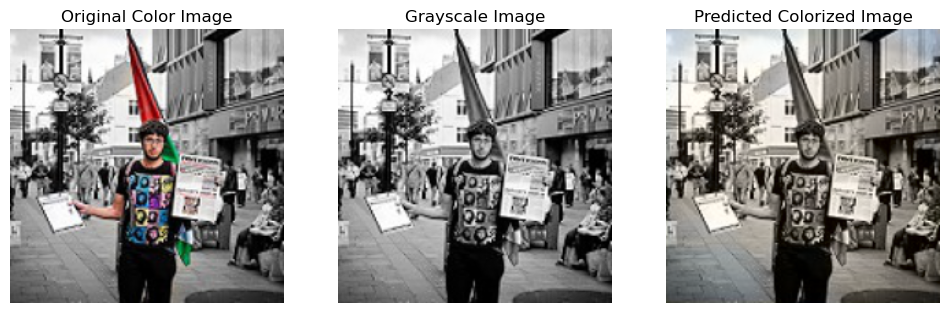

1/1 [==============================] - 0s 135ms/step


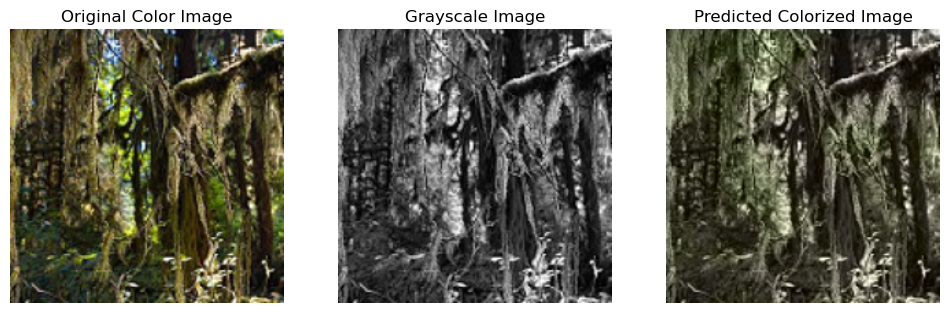

1/1 [==============================] - 0s 141ms/step


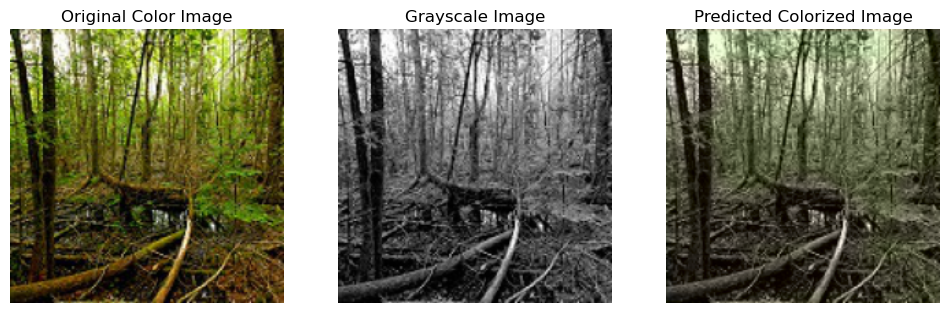

1/1 [==============================] - 0s 73ms/step


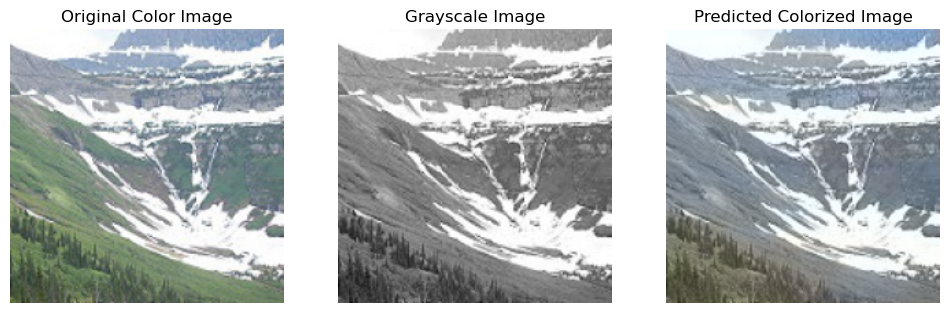

1/1 [==============================] - 0s 85ms/step


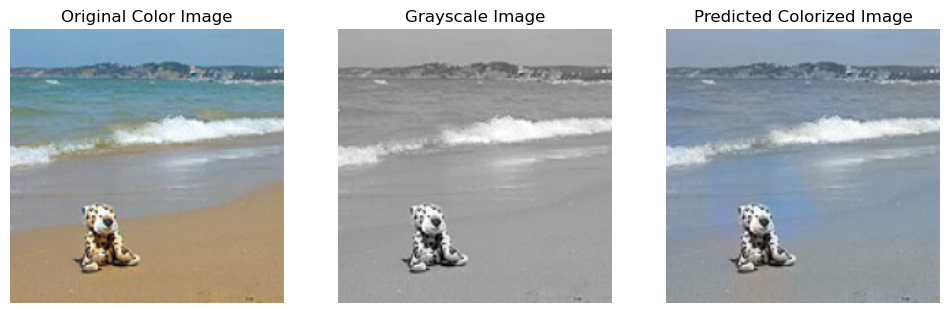

1/1 [==============================] - 0s 72ms/step


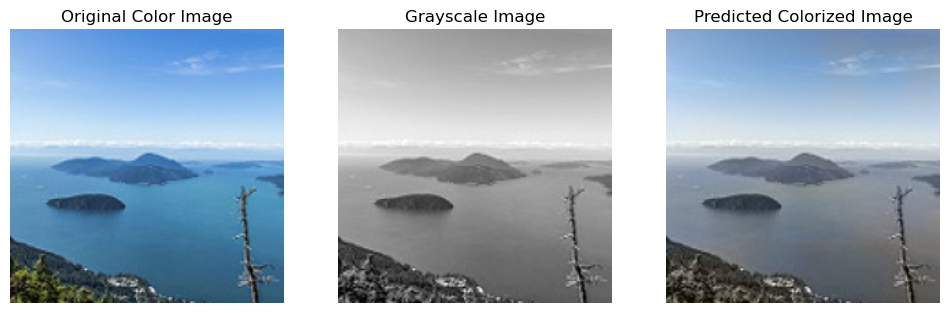

1/1 [==============================] - 0s 63ms/step


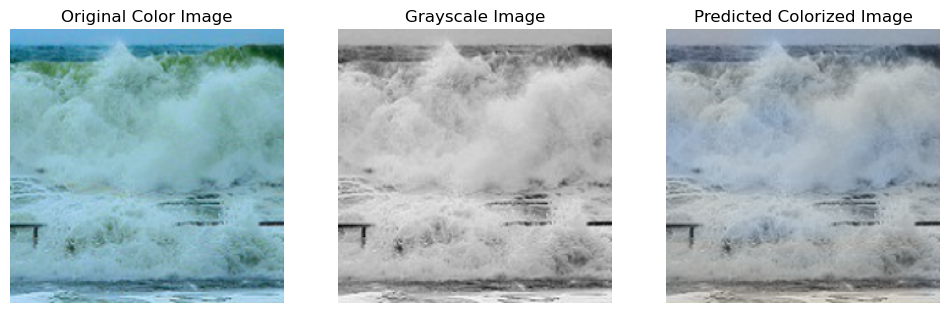

1/1 [==============================] - 0s 61ms/step


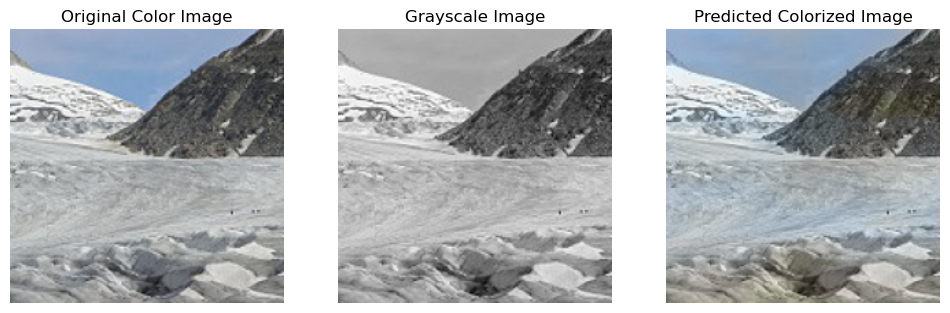

1/1 [==============================] - 0s 68ms/step


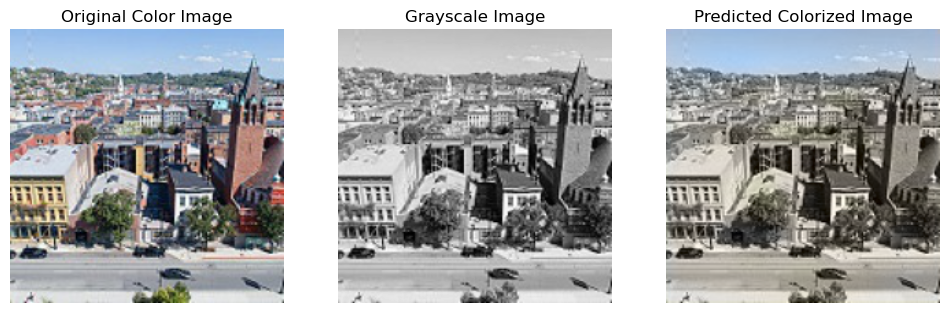

1/1 [==============================] - 0s 66ms/step


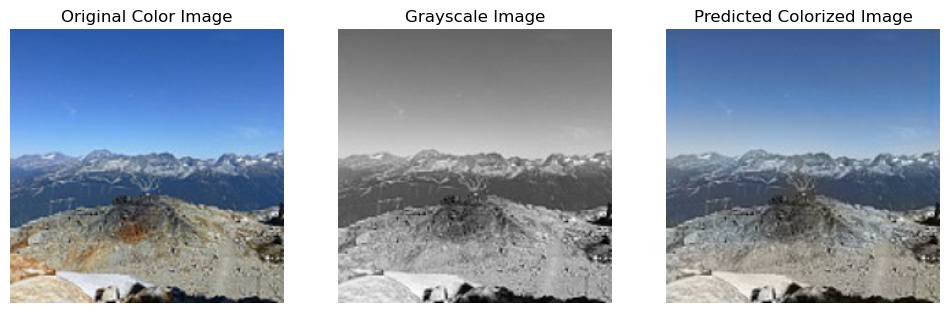

In [ ]:
num_images = 10

for i in range(num_images):

    original_image = color_img_test[i]

    grayscale_t = lab_gray_test_images[i]
    grayscale_t = grayscale_t.reshape(1, 224, 224, 1)
    

    # Predict the colorized image
    predicted_image = acnn.predict(grayscale_t)


    # Rescale the colorized image to original dimensions
    predicted_image = predicted_image * 128.0
    predicted_image = predicted_image.reshape(224, 224, 2)

    # Rescale grayscale input to original dimensions
    grayscale_t = grayscale_t * 100.0
    grayscale_t = grayscale_t.reshape(224, 224, 1)

    #L AND AB CHANNELS FUSED TO FORM IMAGE AND CONVERT IT TO RGB
    lab_image = np.concatenate((grayscale_t, predicted_image), axis=2)
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)


    # Plot the original, grayscale, and colorized images
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original_image)
    axs[0].set_title("Original Color Image")
    axs[0].axis('off')
    axs[1].imshow(grayscale_t.squeeze(), cmap='gray')
    axs[1].set_title("Grayscale Image")
    axs[1].axis('off')
    axs[2].imshow(rgb_image)
    axs[2].set_title("Predicted Colorized Image")
    axs[2].axis('off')

    plt.show()

In [ ]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('inception_resnet_v2_weights.h5')

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=True)

In [ ]:
def create_inception_embedding(gray_imgs):
    #list for storing all embeddings
    
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    
    image_resized = np.array([resize_gray(x) for x in gray_imgs])
    image_preprocessed = preprocess_input(image_resized)
    embed = inception.predict(image_preprocessed)

    return embed

In [ ]:
inception_embedding = create_inception_embedding(gray_img_train)

In [ ]:
inception_embedding_test = create_inception_embedding(gray_img_test)

In [ ]:
inception_embedding.shape

In [ ]:
inception_embedding_test.shape

In [ ]:
def hybridautocnn():

    embed_input = Input(shape=(4096,))
    image_input = Input(shape=(224, 224, 1,))

    # Encoder
    encoder = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(image_input)
    encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
    encoder = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(encoder)
    encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)
    encoder = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(encoder)
    encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)
    encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)
    encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)

    # Fusion
    fusion_output = RepeatVector(28 * 28)(embed_input) 
    fusion_output = Reshape(([28, 28, 1000]))(fusion_output)
    fusion_output = concatenate([encoder, fusion_output], axis=3) 


    # Decoder
    decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(fusion_output)
    decoder = UpSampling2D((2, 2))(decoder)

    decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder)
    decoder = UpSampling2D((2, 2))(decoder)

    decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
    decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(decoder)
    
    decoder_output = Conv2D(2, (3, 3), activation='softmax', padding='same')(decoder)
    output = UpSampling2D((2, 2))(decoder_output)

    # Create the full model
    full_model = Model(inputs=[image_input, embed_input], outputs=output)

    return full_model